In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import *
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import confusion_matrix
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
dataset = pd.read_json('/content/fox-news-comments.json', lines=True)
dataset.head()

,title,text,label,succ,meta,user,mentions,prev
0,German lawmakers approve 'no means no' rape la...,Merkel would never say NO,1,,German lawmakers passed a bill Thursday that w...,barryswallows,,
1,German lawmakers approve 'no means no' rape la...,"Expect more and more women to be asking .. ""wh...",1,,German lawmakers passed a bill Thursday that w...,PostApocalypticHero,,
2,German lawmakers approve 'no means no' rape la...,Groping people in public wasn't already illega...,0,,German lawmakers passed a bill Thursday that w...,californiamojo,,
3,German lawmakers approve 'no means no' rape la...,"Merkel, possible the only person in charge who...",1,,German lawmakers passed a bill Thursday that w...,MikeSte,,
4,German lawmakers approve 'no means no' rape la...,"They know very well, no means NO! They need to...",1,,German lawmakers passed a bill Thursday that w...,scientist,,


In [ ]:
# Adding text-length as a field in the dataset
dataset['text length'] = dataset['text'].apply(len)
print(dataset.head())

                                               title  ... text length
0  German lawmakers approve 'no means no' rape la...  ...          25
1  German lawmakers approve 'no means no' rape la...  ...         141
2  German lawmakers approve 'no means no' rape la...  ...          82
3  German lawmakers approve 'no means no' rape la...  ...         469
4  German lawmakers approve 'no means no' rape la...  ...         100

[5 rows x 9 columns]


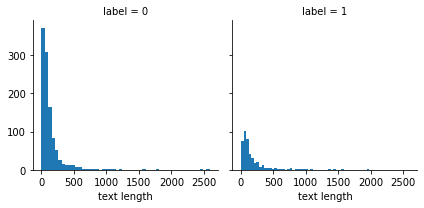

In [ ]:
#Basic visualization of data using histograms
# FacetGrid- Multi-plot grid for plotting conditional relationships

graph = sns.FacetGrid(data = dataset, col ='label')
graph.map(plt.hist, 'text length', bins = 50)

- a.	Distribution of text-length almost seem to be similar across all three classes
- b.	Number of tweets seem to be skewed a lot higher towards the class-1


From the box-plot, looks like the class-1 tweets have much longer text. There are also outliers present so text-length won’t be a useful feature to consider.

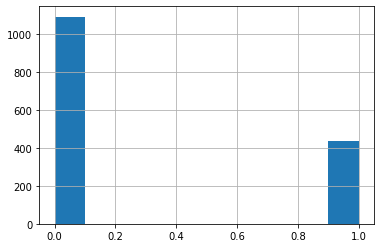

In [ ]:
dataset['label'].hist()

The above histogram shows that most of the tweets are considered to be offensive words by the CF coders.

In [ ]:
# collecting only the tweets from the csv file into a variable name tweet
text = dataset.text

## Preprocessing of the tweets

In [ ]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(text):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    text_space = text.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    text_name = text_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = text.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = text.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtext=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtext=newtext.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtext=newtext.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    text_lower = newtext.str.lower()
    
    # tokenizing
    tokenized_text = text_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_text=  tokenized_text.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the text
    tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_text)):
        tokenized_text[i] = ' '.join(tokenized_text[i])
        text_p= tokenized_text
    
    return text_p

processed_text = preprocess(text)   

dataset['processed_text'] = processed_text
print(dataset[["text","processed_text"]].head(10))

                                                text                                     processed_text
0                          Merkel would never say NO                             merkel would never say
1  Expect more and more women to be asking .. "wh...  expect women ask men longer interest go touch ...
2  Groping people in public wasn't already illega...       grope peopl public alreadi illeg deutschland
3  Merkel, possible the only person in charge who...  merkel possibl person charg wors obama tri har...
4  They know very well, no means NO! They need to...  know well mean need pass law make legal castra...
5             look like merkel just want to get laid                     look like merkel want get laid
6  " but criticized two measures in the bill that...  critic two measur bill could see peopl directl...
7  She said "GO", not "NO" ~ ~ Slime ball Lawyers...                said go slime ball lawyer everywher
8  So, how many sexual assaults would there be if...         man

## Visualizations

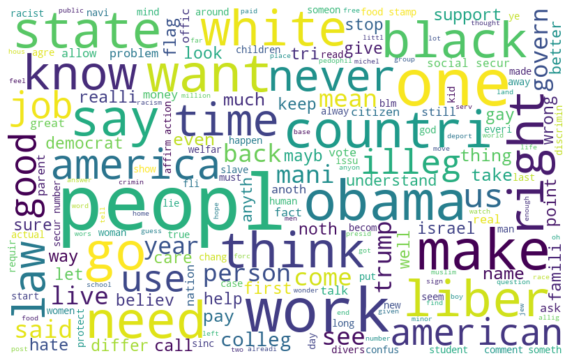

In [ ]:
# visualizing which of the word is most commonly used in the twitter dataset
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in dataset['processed_text'] ])
wordcloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=110).generate(all_words)
random = 0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

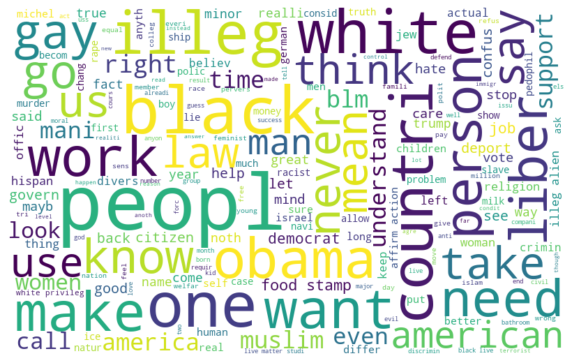

In [ ]:
# visualizing which of the word is most commonly used for hatred speech
hatred_words = ' '.join([text for text in dataset['processed_text'][dataset['label'] == 1]])
wordcloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Feature Engineering

In [ ]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_text'] )
tfidf

<1528x935 sparse matrix of type '<class 'numpy.float64'>'
	with 13210 stored elements in Compressed Sparse Row format>

### Running various model Using TFIDF without additional features

In [ ]:
# If you don't specify the random_state in the code, 
# then every time you run(execute) your code a new random value is generated 
# and the train and test datasets would have different values each time.
X = tfidf
y = dataset['label'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report(y_test, y_preds )
print(report)
acc = accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)


              precision    recall  f1-score   support

           0       0.75      0.98      0.85       222
           1       0.69      0.13      0.22        84

    accuracy                           0.75       306
   macro avg       0.72      0.55      0.53       306
weighted avg       0.73      0.75      0.68       306

Logistic Regression, Accuracy Score: 0.7450980392156863


In [ ]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:", acc1)

              precision    recall  f1-score   support

           0       0.77      0.94      0.84       222
           1       0.60      0.25      0.35        84

    accuracy                           0.75       306
   macro avg       0.68      0.59      0.60       306
weighted avg       0.72      0.75      0.71       306

Random Forest, Accuracy Score: 0.7483660130718954


In [ ]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc2 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:", acc2)

              precision    recall  f1-score   support

           0       0.79      0.47      0.59       222
           1       0.32      0.67      0.43        84

    accuracy                           0.52       306
   macro avg       0.55      0.57      0.51       306
weighted avg       0.66      0.52      0.55       306

Naive Bayes, Accuracy Score: 0.5228758169934641


In [ ]:
support = LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       222
           1       0.56      0.42      0.48        84

    accuracy                           0.75       306
   macro avg       0.68      0.65      0.66       306
weighted avg       0.73      0.75      0.74       306

SVM, Accuracy Score: 0.7483660130718954


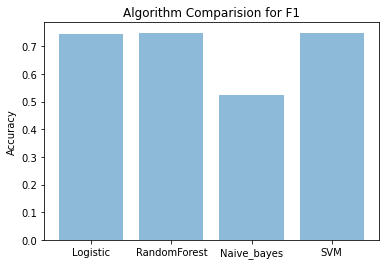

In [ ]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F1')
plt.show()

### Sentiment Analysis, using polarity scores as features

In [ ]:
sentiment_analyzer = VS()
def count_tags(text_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(text):   
    sentiment = sentiment_analyzer.polarity_scores(text)    
    twitter_objs = count_tags(text)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pd.DataFrame(features)
    return features

def sentiment_analysis_array(texts):
    features=[]
    for t in texts:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(text)
#final_features

new_features = pd.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.378,0.622,0.3465,0.0,0.0,0.0
1,0.070,0.104,0.826,0.2695,0.0,0.0,0.0
2,0.000,0.230,0.770,0.5080,0.0,0.0,0.0
3,0.193,0.042,0.766,-0.9413,0.0,0.0,0.0
4,0.232,0.158,0.610,-0.4235,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1523,0.639,0.000,0.361,-0.7263,0.0,0.0,0.0
1524,0.524,0.000,0.476,-0.5106,0.0,0.0,0.0
1525,0.362,0.239,0.399,-0.6199,0.0,0.0,0.0
1526,0.170,0.177,0.653,-0.0421,0.0,0.0,0.0


In [ ]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(1528, 942)

### Running various model Using TFIDF and additional features

In [ ]:
# Running the model Using TFIDF with some features from sentiment analysis

X = pd.DataFrame(modelling_features)
y = dataset['label'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report(y_test, y_preds)
print(report)
acc = accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.76      0.98      0.85       222
           1       0.74      0.17      0.27        84

    accuracy                           0.75       306
   macro avg       0.75      0.57      0.56       306
weighted avg       0.75      0.75      0.69       306

Logistic Regression, Accuracy Score: 0.7549019607843137


In [ ]:
X = pd.DataFrame(modelling_features)
y = dataset['label'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1 = accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:", acc1)

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       222
           1       0.65      0.31      0.42        84

    accuracy                           0.76       306
   macro avg       0.72      0.62      0.64       306
weighted avg       0.75      0.76      0.73       306

Random Forest, Accuracy Score: 0.7647058823529411


In [ ]:
X = pd.DataFrame(modelling_features)
y = dataset['label'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train_bow,y_train)
y_preds = nb.predict(X_test_bow)
acc2 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Naive Bayes, Accuracy Score:", acc2)

              precision    recall  f1-score   support

           0       0.80      0.50      0.62       222
           1       0.34      0.67      0.45        84

    accuracy                           0.55       306
   macro avg       0.57      0.59      0.53       306
weighted avg       0.67      0.55      0.57       306

Naive Bayes, Accuracy Score: 0.5490196078431373


In [ ]:
X = pd.DataFrame(modelling_features)
y = dataset['label'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support = LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       222
           1       0.56      0.42      0.48        84

    accuracy                           0.75       306
   macro avg       0.68      0.65      0.66       306
weighted avg       0.73      0.75      0.74       306

SVM, Accuracy Score: 0.7516339869281046


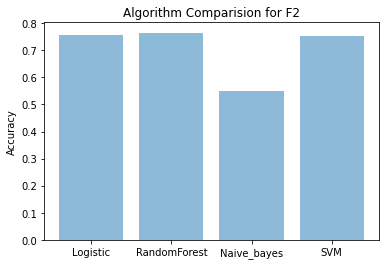

In [ ]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F2')
plt.show()

In [ ]:
# create doc2vec vector columns
# Initialize and train the model
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#The input for a Doc2Vec model should be a list of TaggedDocument(['list','of','word'], [TAG_001]). 
#A good practice is using the indexes of sentences as the tags.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["processed_text"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
# window- The maximum distance between the current and predicted word within a sentence.
# mincount-Ignores all words with total frequency lower than this.
# workers -Use these many worker threads to train the model
#  Training Model - distributed bag of words (PV-DBOW) is employed.
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

#infer_vector - Infer a vector for given post-bulk training document.
# Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
# doc_words-A document for which the vector representation will be inferred.

# transform each document into a vector data
doc2vec_df = dataset["processed_text"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,-0.048442,0.024249,-0.093960,-0.043650,0.004159
1,-0.106347,0.083327,-0.078693,0.034470,0.067991
2,-0.084746,0.052269,0.018845,0.025214,0.054784
3,-0.122753,0.085237,-0.136653,-0.028619,0.013276
4,-0.043968,0.067098,0.054489,-0.057436,-0.013149
...,...,...,...,...,...
1523,-0.035567,0.021551,-0.025144,-0.056804,-0.068657
1524,-0.026822,-0.006892,-0.058361,0.081557,0.078464
1525,-0.001543,0.000220,0.063319,0.033500,0.037252
1526,-0.068200,0.040311,-0.087703,0.066776,0.018839


In [ ]:
# conctaenation of tf-idf scores, sentiment scores and doc2vec columns
modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
modelling_features.shape

(1528, 947)

### Running the models Using TFIDF with additional features from sentiment analysis and doc2vec

In [ ]:
X = pd.DataFrame(modelling_features)
y = dataset['label'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report(y_test, y_preds)
print(report)
acc = accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.76      0.98      0.85       222
           1       0.78      0.17      0.27        84

    accuracy                           0.76       306
   macro avg       0.77      0.57      0.56       306
weighted avg       0.76      0.76      0.70       306

Logistic Regression, Accuracy Score: 0.7581699346405228


In [ ]:
X = pd.DataFrame(modelling_features)
y = dataset['label'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:", acc1)

              precision    recall  f1-score   support

           0       0.76      0.95      0.85       222
           1       0.63      0.20      0.31        84

    accuracy                           0.75       306
   macro avg       0.69      0.58      0.58       306
weighted avg       0.72      0.75      0.70       306

Random Forest, Accuracy Score: 0.7483660130718954


In [ ]:
X = pd.DataFrame(modelling_features)
y = dataset['label'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Naive Bayes, Accuracy Score:", acc2)

              precision    recall  f1-score   support

           0       0.80      0.50      0.62       222
           1       0.34      0.67      0.45        84

    accuracy                           0.55       306
   macro avg       0.57      0.59      0.53       306
weighted avg       0.67      0.55      0.57       306

Naive Bayes, Accuracy Score: 0.5490196078431373


In [ ]:
X = pd.DataFrame(modelling_features)
y = dataset['label'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support = LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       222
           1       0.55      0.38      0.45        84

    accuracy                           0.75       306
   macro avg       0.67      0.63      0.64       306
weighted avg       0.72      0.75      0.73       306

SVM, Accuracy Score: 0.7450980392156863


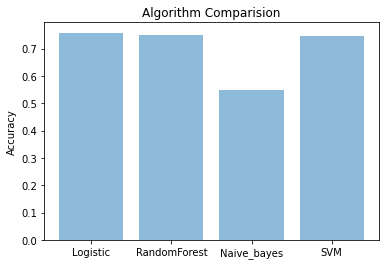

In [ ]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align = 'center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

In [ ]:
#Using TFIDF with sentiment scores,doc2vec and enhanced features
def additional_features(text): 
    
    syllables = textstat.syllable_count(text)
    num_chars = sum(len(w) for w in text)
    num_chars_total = len(text)
    num_words = len(text.split())
    # avg_syl = total syllables/ total words
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(text.split()))
    
    #  Flesch–Kincaid readability tests are readability tests 
    ###Modified FK grade, where avg words per sentence is : just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    add_features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_words,
                num_unique_terms]
    return add_features

def get_additonal_feature_array(texts):
    features = []
    for t in texts:
        features.append(additional_features(t))
    return np.array(features)

fFeatures = get_additonal_feature_array(processed_text)

In [ ]:
tfidf_a = tfidf.toarray()
modelling_features_enhanced = np.concatenate([tfidf_a,final_features,doc2vec_df,fFeatures],axis=1)
modelling_features_enhanced.shape

(1528, 955)

### Running the models Using TFIDF with sentiment scores,doc2vec and enhanced features

In [ ]:
# Running the model Using TFIDF with enhanced features

X = pd.DataFrame(modelling_features_enhanced)
y = dataset['label'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

model = LogisticRegression().fit(X_train_features,y_train)
y_preds = model.predict(X_test_features)
report = classification_report(y_test, y_preds)
print(report)
acc = accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       221
           1       0.68      0.25      0.36        85

    accuracy                           0.76       306
   macro avg       0.72      0.60      0.61       306
weighted avg       0.74      0.76      0.72       306

Logistic Regression, Accuracy Score: 0.7581699346405228


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_preds)
print("Accuracy = ",metrics.accuracy_score(y_test, y_preds)*100)

Accuracy =  75.81699346405229


In [ ]:
testing_index=list(X_test_features.index[0:10])
#print(testing_index)
print("Predicted Class:",y_preds[0:10])
print("Actual Class:",y_test.tolist()[0:10])

Predicted Class: [0 1 0 1 0 0 0 0 0 0]
Actual Class: [0, 0, 1, 1, 0, 0, 1, 0, 0, 1]


Text(0, 0.5, 'Count')

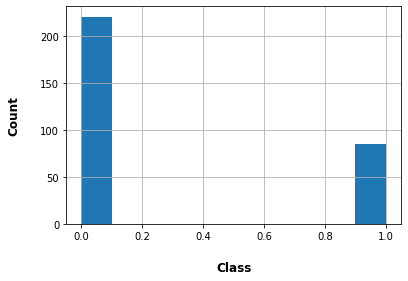

In [ ]:
# Histogram presenting the count of different classes- Actual
ax=y_test.hist()
ax.set_xlabel("Class", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

Text(0, 0.5, 'Count')

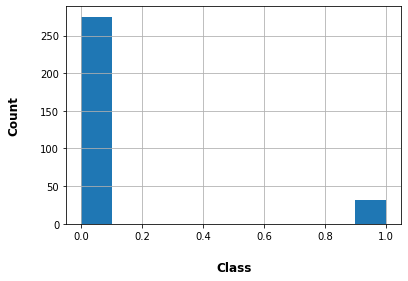

In [ ]:
# Histogram presenting the count of different classes- Predicted
ax = pd.Series(y_preds).hist()
ax.set_xlabel("Class", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

In [ ]:
X = pd.DataFrame(modelling_features_enhanced)
y = dataset['label'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train_features,y_train)
y_preds = rf.predict(X_test_features)
acc1 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:", acc1)

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       221
           1       0.69      0.21      0.32        85

    accuracy                           0.75       306
   macro avg       0.73      0.59      0.59       306
weighted avg       0.74      0.75      0.70       306

Random Forest, Accuracy Score: 0.7549019607843137


In [ ]:
X = pd.DataFrame(modelling_features_enhanced)
y = dataset['label'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train_features,y_train)
y_preds = nb.predict(X_test_features)
acc2 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Naive Bayes, Accuracy Score:", acc2)

              precision    recall  f1-score   support

           0       0.77      0.62      0.69       221
           1       0.34      0.52      0.41        85

    accuracy                           0.59       306
   macro avg       0.56      0.57      0.55       306
weighted avg       0.65      0.59      0.61       306

Naive Bayes, Accuracy Score: 0.5915032679738562


In [ ]:
X = pd.DataFrame(modelling_features_enhanced)
y = dataset['label'].astype(int)
X_train_features, X_test_features, y_train, y_test_helo = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test_helo,y_preds)
report = classification_report(y_test_helo, y_preds)
print(report)
print("SVM, Accuracy Score:" ,acc3 )

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       221
           1       0.44      0.20      0.27        85

    accuracy                           0.71       306
   macro avg       0.59      0.55      0.54       306
weighted avg       0.66      0.71      0.67       306

SVM, Accuracy Score: 0.7058823529411765


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


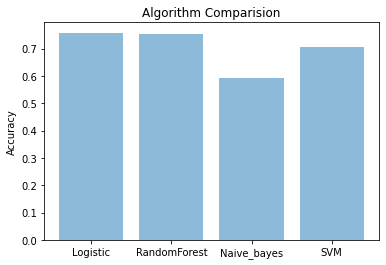

In [ ]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

## Combining different features

In [ ]:
#f1, f3 and f4 combined
tfidf_a = tfidf.toarray()
modelling_features_one = np.concatenate([tfidf_a,doc2vec_df,fFeatures],axis=1)
modelling_features_one.shape

(1528, 948)

In [ ]:
X = pd.DataFrame(modelling_features_one)
y = dataset['label'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support = LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3 )

              precision    recall  f1-score   support

           0       0.75      0.82      0.79       221
           1       0.39      0.29      0.34        85

    accuracy                           0.68       306
   macro avg       0.57      0.56      0.56       306
weighted avg       0.65      0.68      0.66       306

SVM, Accuracy Score: 0.6764705882352942


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
#f1, f2 and f4 combined
tfidf_a = tfidf.toarray()
modelling_features_two = np.concatenate([tfidf_a,final_features,fFeatures],axis=1)
modelling_features_two.shape

(1528, 950)

In [ ]:
X = pd.DataFrame(modelling_features_two)
y = dataset['label'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3 )

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       221
           1       0.45      0.21      0.29        85

    accuracy                           0.71       306
   macro avg       0.60      0.56      0.55       306
weighted avg       0.67      0.71      0.67       306

SVM, Accuracy Score: 0.7091503267973857


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
#f2, f3 and f4 combined
modelling_features_three = np.concatenate([final_features,fFeatures],axis=1)
modelling_features_three.shape

(1528, 15)

In [ ]:
X = pd.DataFrame(modelling_features_three)
y = dataset['label'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support = LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3 )

              precision    recall  f1-score   support

           0       0.73      0.92      0.81       221
           1       0.35      0.11      0.16        85

    accuracy                           0.70       306
   macro avg       0.54      0.51      0.49       306
weighted avg       0.62      0.70      0.63       306

SVM, Accuracy Score: 0.696078431372549


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
X = pd.DataFrame(modelling_features_two)
y = dataset['label'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train_features,y_train)
y_preds = nb.predict(X_test_features)
acc2 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Naive Bayes, Accuracy Score:", acc2)

              precision    recall  f1-score   support

           0       0.77      0.62      0.69       221
           1       0.34      0.52      0.41        85

    accuracy                           0.59       306
   macro avg       0.56      0.57      0.55       306
weighted avg       0.65      0.59      0.61       306

Naive Bayes, Accuracy Score: 0.5915032679738562


In [ ]:
X = pd.DataFrame(modelling_features_two)
y = dataset['label'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

model = LogisticRegression().fit(X_train,y_train)
y_preds = model.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)
acc = accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.78      0.95      0.86       221
           1       0.71      0.28      0.40        85

    accuracy                           0.77       306
   macro avg       0.74      0.62      0.63       306
weighted avg       0.76      0.77      0.73       306

Logistic Regression, Accuracy Score: 0.7679738562091504


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
X = pd.DataFrame(modelling_features_three)
y = dataset['label'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_preds = rf.predict(X_test)
acc1 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:", acc1)

              precision    recall  f1-score   support

           0       0.73      0.85      0.79       221
           1       0.34      0.20      0.25        85

    accuracy                           0.67       306
   macro avg       0.54      0.53      0.52       306
weighted avg       0.62      0.67      0.64       306

Random Forest, Accuracy Score: 0.6699346405228758
